#Import

In [28]:
#!pip install rioxarray
#only need to run the line above once

import os
import numpy as np
import xarray as xr
import pandas as pd
import rioxarray as rio
import matplotlib.pyplot as plt
from glob import glob

#connect the google drive to download and upload data
from google.colab import drive
drive.mount('/content/drive')
#set the path to the drive data folder
directory = '/content/drive/MyDrive/MLFall2022/CurrentProject/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#download the data 
#all of our data contains NaN which we will remove later on in the formatting
ecoregion_data = xr.open_dataset(directory + 'epa_level2.nc')
forest_type_data = xr.open_dataset(directory + 'forest_type_frac.nc')
burnarea_data = xr.open_dataset(directory + 'burnarea_combined.nc')

burnarea_data = burnarea_data.rio.set_spatial_dims(x_dim='X', y_dim='Y', inplace=True)
#set the working timeframe, based on the available data
firsttime = "1984-01-15"
finaltime = "2019-12-15"
#important to cut to the dataframe #check with print(burnarea.time)
burnarea = burnarea_data.burnarea.loc[firsttime:finaltime]
#to see the data in an easy format
#dfba = burnarea.to_dataframe().dropna()
#burnarea_data


In [30]:
#import additional data 
ea = xr.open_dataset(directory + 'ea.nc')
es = xr.open_dataset(directory + 'es.nc')
rh = xr.open_dataset(directory + 'rh.nc') 
tmax = xr.open_dataset(directory + 'tmax.nc') 
prec = xr.open_dataset(directory + 'prec.nc') 
wind = xr.open_dataset(directory + 'wind.nc') 
elevstd = xr.open_dataset(directory + 'elevstd.nc') 
wui_distance = xr.open_dataset(directory + 'wui_distance.nc')

#cut the data to the dataframe
vpd = es.es.loc[firsttime:finaltime] - ea.ea.loc[firsttime:finaltime]
rh = rh.rh.loc[firsttime:finaltime]
tmax = tmax.tmax.loc[firsttime:finaltime]
prec = prec.prec.loc[firsttime:finaltime]
wind = wind.wind.loc[firsttime:finaltime]

#Formatting

In [32]:
# add up the forest percentages for each forest type 
forest = forest_type_data.sum(dim='ftype').forest_type_frac
burnarea = burnarea*forest.values 

#set data variables
time = burnarea.time
epa_l2 = ecoregion_data.epa_level2
province = epa_l2.province

#update the data
for thisregion in province: 
  tmpavg = (vpd*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
  vpd_z = vpd*epa_l2[thisregion] - tmpavg
  tmpavg = (rh*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
  rh_z = rh*epa_l2[thisregion] - tmpavg
  tmpavg = (tmax*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
  tmax_z = tmax*epa_l2[thisregion] - tmpavg
  tmpavg = (prec*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
  prec_z = tmax*epa_l2[thisregion] - tmpavg

# convert wui distance into variable for all years
firstyear = pd.DatetimeIndex(burnarea.time.values).year.min()
finalyear = pd.DatetimeIndex(burnarea.time.values).year.max()
years = np.arange(firstyear, finalyear+1, 1)
# interpolate to fill in years
wui_distance_new = wui_distance.wui_distance.interp(year=years) 

In [33]:
maskUS = ~np.isnan(burnarea.isel(time=0))

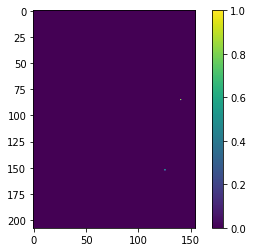

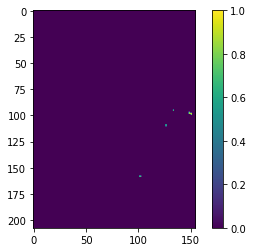

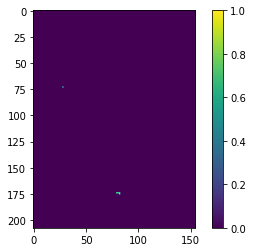

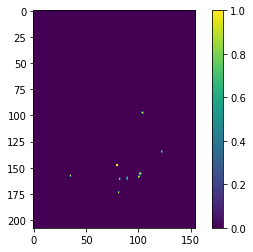

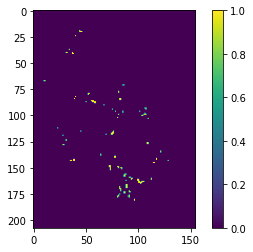

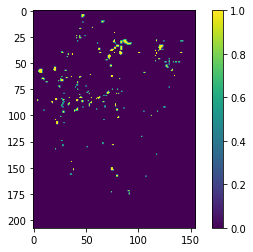

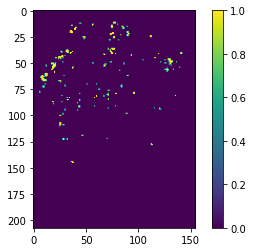

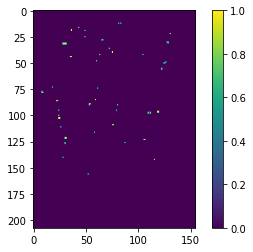

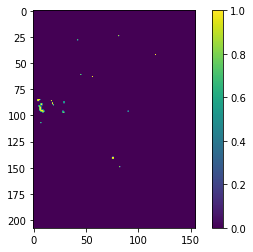

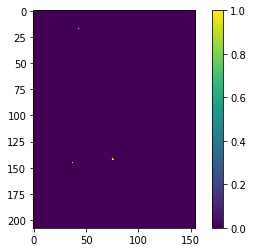

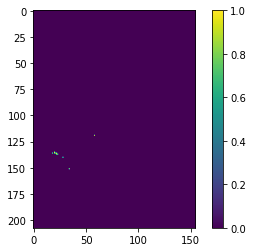

In [35]:
#show burned area in the years 2015, 2017, and 2020 (‘Wildfires and Climate Change’, 2022)
#time2017 = burnarea.time[396:409] #2017-01-15 to 2018-01-15

#turns all data burnarea to false, in order to have the graph as one whole surface, 
#without the distinction between the land and ocean
#makes the graph much more clear 
burnyes_month = (burnarea > 0)

index = 1
#in order to plot all wanted months, we need to get rid of the NaN values
#since we are working with 3d array for now we will just skip them 
#NaNs are shown as a single color filled graph
for month in burnyes_month.time[396:409]:
  if (burnyes_month.sel(time=month).any() == False):
    continue 
  fig, ax = plt.subplots()
  this = ax.imshow(burnyes_month.sel(time=month))
  fig.colorbar(this)
  index += 1

In [64]:
#resampling the data yearly 
burnno_yr = burnarea.resample(indexer={'time':'Y'}).sum(skipna=True) 
burnno_yr = (burnno_yr==0).astype(int)

#extract dimension info
time = burnno_yr.time
X = burnno_yr.X
Y = burnno_yr.Y
#initialize storage
return_years = np.zeros((len(time), len(Y), len(X))) 

#loop through
index = 1
for year in burnno_yr.time[index:]:
  tmp_thisyr = burnno_yr.isel(time=index) 
  tmp_prevyr = return_years[index-1] 
  tmp_return = tmp_thisyr + tmp_prevyr 
  tmp_return = tmp_return.where(tmp_thisyr>0, other=0) 
  return_years[index] = tmp_return
  index+=1

#transform return_years into a xarray DataArray
return_years = xr.DataArray(data=return_years, dims=['time','Y','X'], coords=dict(X=X, Y=Y, time=time), attrs=dict(description='Time since gridcell last burned', units='years'))
#remove NaN
return_years = return_years.where(maskUS) 

In [65]:
#compute the monthly data
burnno_mo = (burnarea==0).astype(int)
time = burnno_mo.time
X = burnno_mo.X
Y = burnno_mo.Y

return_months = np.zeros((len(time), len(Y), len(X))) 

index = 1
for year in burnno_mo.time[index:]:
  tmp_thismo = burnno_mo.isel(time=index) 
  tmp_prevmo = return_months[index-1] 
  tmp_return = tmp_thismo + tmp_prevmo 
  tmp_return = tmp_return.where(tmp_thisyr>0, other=0) 
  return_months[index] = tmp_return 
  index+=1
  
burn_np = burnarea.values
burn_np2d = burn_np.reshape(burn_np.shape[0], -1)
burn_np[np.isnan(burn_np)] = 0

In [66]:
#format monthly data
return_months = xr.DataArray(data=return_months,
                            dims=['time','Y','X'],
                            coords=dict(X=X, Y=Y, time=time),
                            attrs=dict(
                                description='Time since gridcell last burned',
                                units='months'
                            ))

return_months = return_months.where(maskUS) 

In [68]:
# format variables
time = burnarea.time
elev_np = elevstd.values
vpd_np = vpd.values
rh_np = rh.values
tmax_np = tmax.values
prec_np = prec.values
wind_np = wind.values 
vpdz_np = vpd_z.values
rhz_np = rh_z.values
tmaxz_np = tmax_z.values 
burn_np = burnarea.values 
wui_np = wui_distance_new.values
returnm_np = return_months.values 


In [70]:
#shape the data
wind_np2d = wind_np.reshape(wind_np.shape[0], -1)
vpdz_np2d = vpdz_np.reshape(vpdz_np.shape[0], -1)
vpd_np2d = vpd_np.reshape(vpd_np.shape[0], -1)
tmax_np2d = tmax_np.reshape(tmax_np.shape[0], -1)
tmaxz_np2d = tmaxz_np.reshape(tmaxz_np.shape[0], -1)
burn_np2d = burn_np.reshape(burn_np.shape[0], -1)
returnm_np2d = returnm_np.reshape(returnm_np.shape[0], -1)

In [71]:
#remove NaNs
wind_np[np.isnan(wind_np)] = 0
vpdz_np[np.isnan(vpdz_np)] = 0
tmaxz_np[np.isnan(tmaxz_np)] = 0
burn_np[np.isnan(burn_np)] = 0
returnm_np[np.isnan(returnm_np)] = 0

#Improved Training

In [72]:
#trim the dataset 
def trim(x):
  #make divisible by 10 to make separate datapoints later
  return x[:,:200,:150] 
def swap(x):
  #swap time dim to end
  return np.swapaxes(x, 0, 2)
#define each feature
feature1 = swap(trim(wind_np)) 
feature2 = swap(trim(vpdz_np)) 
feature3 = swap(trim(tmaxz_np)) 
feature4 = swap(trim(burn_np)) 
feature5 = swap(trim(returnm_np))
#stack and create the dataset
dataset = np.stack([feature1,
                    feature2,
                    feature3,
                    feature4,
                    feature5])
dataset = np.transpose(dataset,(3,1,2,0)) 

In [73]:
#break spatial data into (blocksize,blocksize) blocks
new_data = []
blocksize = 10
dim1=dataset.shape[1]
dim2=dataset.shape[2]
#change from (timesteps, dim1, dim2, channels) to (datapoints, timesteps, blocksize, blocksize, channels) 
for i in range(int(dim1/blocksize)):
  x_start = i*blocksize
  x_end = x_start + blocksize
  for j in range(int(dim2/blocksize)):
    y_start = j*blocksize
    y_end = y_start+blocksize
    datapoint = dataset[:,x_start:x_end,y_start:y_end,:]
    new_data.append(datapoint)
dataset_10 = np.stack(new_data) #print(dataset_10.shape)

#split data
train_dataset = dataset_10[:,:232,:,:,:]
test_dataset = dataset_10[:,232:,:,:,:] 

In [74]:
#splits dataset into (input,output)
def make_input_output(dataset):
  #dataset is (N,time,dim1,dim2,channels)
  timesteps = dataset.shape[1]
  burned_area_channel = 0
  #shift targets y by one timestep from x as in demo 
  #burned area channel used for outputs
  x = dataset[:, 0 : timesteps - 1, :,:,:]
  y = dataset[:, 1 : timesteps , :,:,burned_area_channel]
  return x,y

x_train,y_train = make_input_output(train_dataset)
x_val,y_val = make_input_output(test_dataset)

In [75]:
#code to test gpu speed up over cpu
#also initialized gpu and configures it

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
#we run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

#run the op several times
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6166673220013763
GPU (s):
0.03676845600057277
GPU speedup over CPU: 98x


In [76]:
#in the event the instance running on a tpu this code will initialize it for performance gains
print("Tensorflow version " + tf.__version__)

try:
  #TPU detenction
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

#initialize a Google TPU to accelerate Tensor flow math and training
#CPUs are slow and outdate for this TPU gang

Tensorflow version 2.9.2


BaseException: ignored

In [77]:
from tensorflow.keras import layers
from tensorflow import keras

inp = layers.Input(shape=(None, *x_train.shape[2:]))
#density layer improves efficiency of loss training
x = layers.Dense(16, activation='sigmoid')
x = layers.Dropout(0.2) #Drop out regulization to reduce risk of overfit
x = layers.ConvLSTM2D( filters=8, kernel_size=(5, 5), padding="same", return_sequences=True, activation="sigmoid",)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=8, kernel_size=(3, 3), padding="same", return_sequences=True, activation="sigmoid",)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=8, kernel_size=(1, 1), padding="same", return_sequences=True, activation="sigmoid",)(x)
#assuming binary targets here, but see below for another option
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same")(x)

#build the complete model and compile it.
model = keras.models.Model(inp, x)

#compile model and enable jit compilation of the model to native
#native compilation speeds this up roughly 3.5x per epoch
#using relu on the last layer + mean squared error to predict the area that will burn
#switching to adamax optimizer over adam to take advtange of the fact extreme gradient boosting improves lstm capabilties
#while using adamax is not as good as transferal training with xgboost it is pretty good and xgboost has some issues with the data when attempted
#so this is a nice compromise that works
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adamax(),metrics=['accuracy'], jit_compile=True)


In [80]:
#define some callbacks to improve training
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
#define modifiable training hyperparameters.
epochs = 20
batch_size = 5

In [ ]:
from numba import jit
#fit the model to the training data and jit the function call with numba
#while the model itself is already compiled in native this jits the function to fit the data aswell giving a small speed up ~roughly 30%
@jit(forceobj=True)
def trainModel(X_train, y_train, batch_size, epochs, x_val, y_val, early_stopping, reduce_lr):
  x_val = x_val
  y_val = y_val
  early_stopping = early_stopping
  reduce_lr = reduce_lr
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr],)
  return history

history = trainModel(x_train, y_train, batch_size, epochs, x_val, y_val, early_stopping, reduce_lr)

Epoch 1/20
60/60 [==============================] - 40s 526ms/step - loss: 1.8523 - accuracy: 0.0128 - val_loss: 2.1242 - val_accuracy: 2.6298e-05 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 27s 446ms/step - loss: 1.1032 - accuracy: 0.0091 - val_loss: 1.9651 - val_accuracy: 3.6348e-05 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 26s 438ms/step - loss: 1.0069 - accuracy: 0.0384 - val_loss: 1.7688 - val_accuracy: 2.6298e-05 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 21s 346ms/step - loss: 0.8102 - accuracy: 0.0739 - val_loss: 1.5021 - val_accuracy: 2.6633e-05 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 22s 361ms/step - loss: 0.7359 - accuracy: 0.0784 - val_loss: 1.2205 - val_accuracy: 0.0022 - lr: 0.0010
Epoch 6/20
30/60 [==============>...............] - ETA: 7s - loss: 0.8102 - accuracy: 0.0625

1/1 [==============================] - 0s 18ms/step


Text(0.5, 0.98, 'Plotting for group 283')

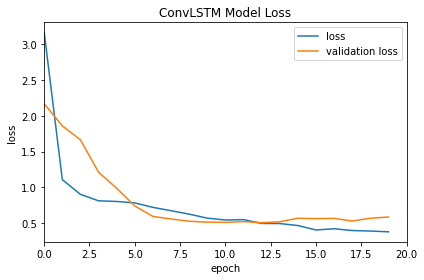

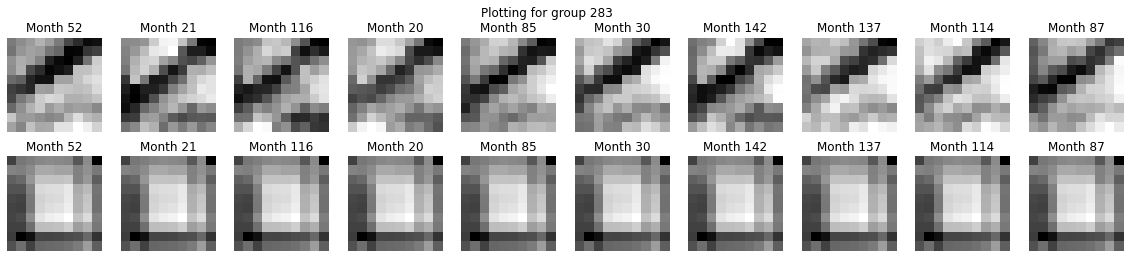

In [57]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('ConvLSTM Model Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
ax.axis(xmin=0,xmax=20)
fig.tight_layout()

np.shape(x_val)
#select a few random examples from the dataset
rand = np.random.choice(range(len(test_dataset)), size=5)
example = x_train[rand[0]]
#pick 10 randomized frames from the example
rand2 = np.random.choice(range(199), size=10)
frames = example[rand2, ...]
frames_new = np.empty((10, 10, 10))

original_frames = y_train[rand[0],rand2, ...]
#predict a new set of 10 frames.
for _ in range(10):
  #extract the model's prediction and post-process it 
  new_prediction = model.predict(np.expand_dims(frames, axis=0)) 
  new_prediction = np.squeeze(new_prediction)
  new_prediction = np.squeeze(new_prediction)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  #extend the set of prediction frames.
  frames_new = np.concatenate((frames_new, predicted_frame)) 

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]): 
  ax.imshow(np.squeeze(original_frames[idx]), cmap="gray") 
  ax.set_title(f"Month {rand2[idx]}")
  ax.axis("off")
new_frames = frames_new[10:, ...] 

for idx, ax in enumerate(axes[1]):
  ax.imshow(np.squeeze(new_frames[idx]), cmap="gray") 
  ax.set_title(f"Month {rand2[idx]}")
  ax.axis("off")
fig.suptitle(f"Plotting for group {rand[0]}")

#RF Draft

In [ ]:
#some definitions taken from the utils file from the course's provided files
def prepare_predictor(data_sets,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """
        
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for file in data_sets:
        X_all.append(file)
        length_all.append(len(file.time))
    
    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        Y_all.append(file)
        length_all.append(len(file.time))
    
    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time')
    Y = Y.rename({'X':'longitude','Y': 'latitude'}).transpose('time','latitude', 'longitude')
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y, length_all

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#X = time
#Y = burnarea

train_files = [burnarea_data]#, vpd, rh, tmax, wind, prec]

x_train_xr, x_length  = prepare_predictor(train_files)
y_train_xr, y_length  = prepare_predictand(train_files)

#Test set
#X_test_xr, _ = prepare_predictor(train_files)
#y_test_xr, _ = prepare_predictand(train_files)

ValueError: ignored

In [ ]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(10336032, 1) (10336032, 1) (10336032, 1)


In [ ]:
n_estimators      = 100    # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'auto' # Number of features to consider at every split
max_depth         = 25     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(X_train,y_train)

<ipython-input-22-7ae8c9cf85b5>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tas = reg0.fit(X_train,y_train)


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [ ]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
#takes very long time
rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The best hyperparameters: 
 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 25, 'bootstrap': True}


In [ ]:
y_test_pre = rf_tas.predict(X_test)
#y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.X.values, 
                               'longitude': X_test_xr.Y.values},
                        data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

ValueError: ignored

NameError: ignored

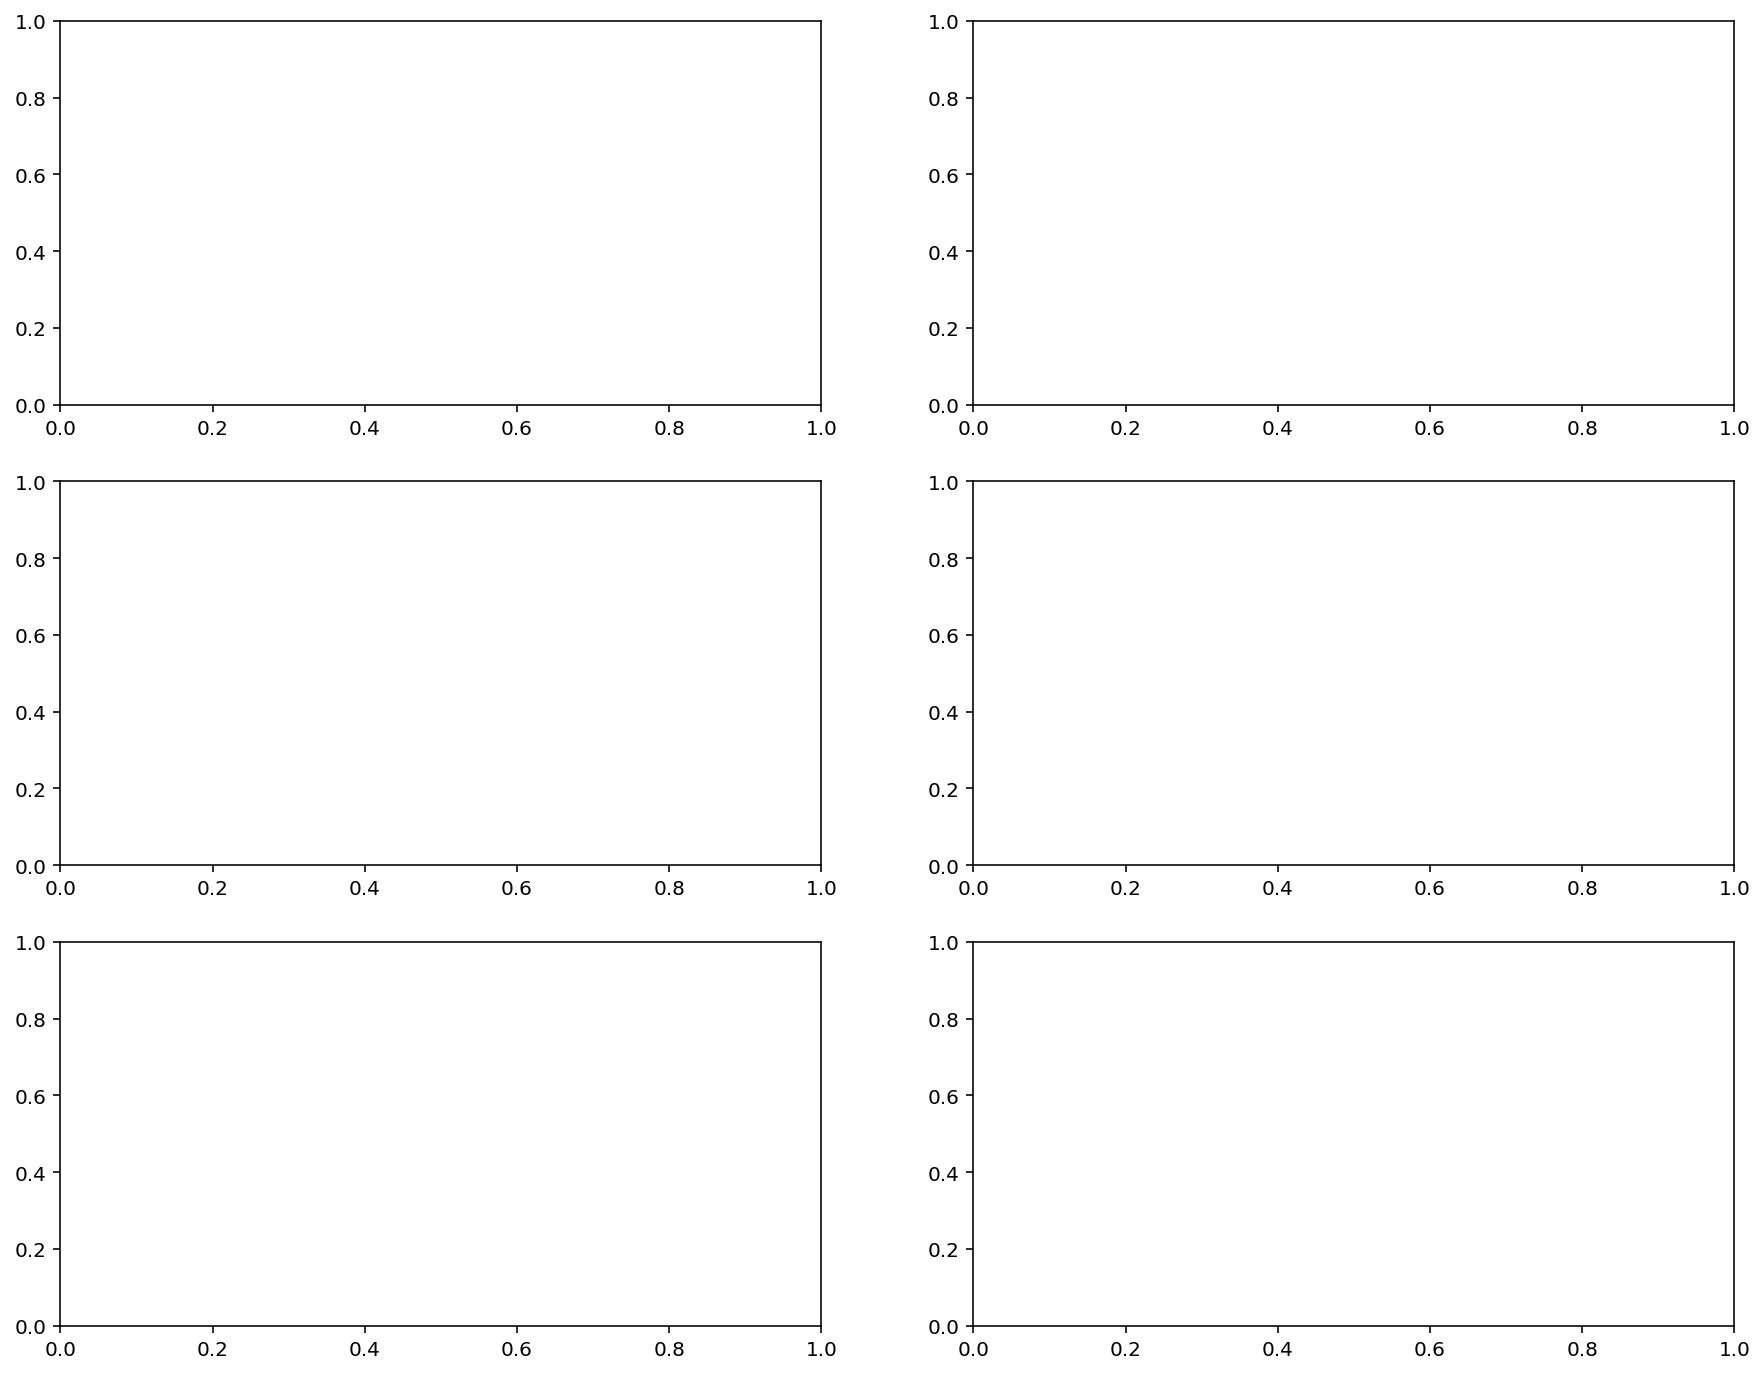

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()